In [1]:
import os
import numpy as np
import math
import time
import copy
from PIL import Image
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from torch.nn import AdaptiveAvgPool3d
from typing import Sequence
from tqdm import trange, tqdm

In [2]:
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
class C4(nn.Module):

    def __init__(self, order):
        super().__init__()
        self.dimension = 1 
        self.register_buffer('identity', torch.Tensor([0.]))
        self.order = torch.tensor(order)

    def elements(self):
        return torch.tensor([0., np.pi / 2, np.pi, 3 * np.pi / 2])
    
    def product(self, h, h_prime):
        return torch.remainder(h + h_prime, 2 * np.pi)
    
    def inverse(self, h):
        return torch.remainder(-h, 2 * np.pi)
    
    def left_action_on_R2(self, h, x):
        return torch.tensordot(self.matrix_representation(h), x, dims=1)
    
    def matrix_representation(self, h):
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)
        representation = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)
        return representation
    
    def normalize_group_elements(self, h):
        return (2*h / (3 * np.pi / 2)) - 1

In [4]:
# tests to verify implementation

c4 = C4(order=4)
e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e

assert torch.allclose(c4.matrix_representation(e), torch.eye(2))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1, 0], [0, -1]]).float(), atol=1e-6)

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0.]), atol=1e-7)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
img = Image.open("peppers.png")
img_tensor = transforms.ToTensor()(img)

In [6]:
def bilinear_interpolation(signal, grid):

    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)

    # this just switches the order so the 2 for x and y are at the end 
    grid = grid.permute(1, 2, 3, 0)
    grid = torch.roll(grid, shifts=1, dims=-1)
    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear"
    )

In [7]:
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))

transformed_img_grid = c4.left_action_on_R2(c4.inverse(g3), img_grid)
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]

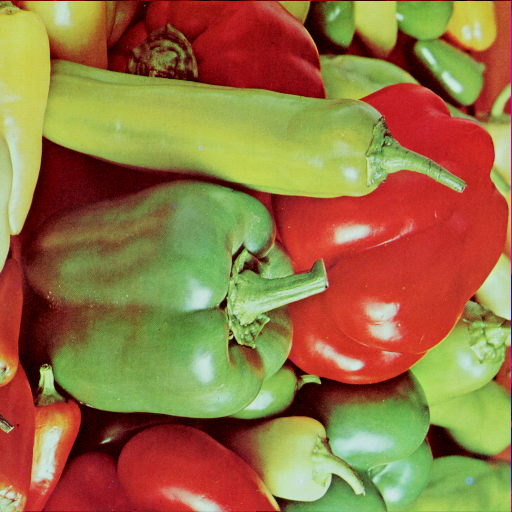

In [8]:
transforms.ToPILImage()(transformed_img)

## Lifting Convolution

In [9]:
class LiftingKernel(nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        """Implements a base class for the lifting kernel. Stores the R2 grid over which the lifting kernel is defined and it's transformed copies under the action of a group H"""

        super().__init__()
        self.group = group
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing="ij"
        )).to(self.group.identity.device))

        # registering the transformed grids after applying elements in this group
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

        # creating the set of weights, which we interpolate to create transformed spatial kernels
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels, 
            self.in_channels, 
            self.kernel_size, 
            self.kernel_size
        ), device=self.group.identity.device))

        # initializing the weight
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element. This yields a grid over H of spatial grids over R2."""

        group_elements = self.group.elements()

        transformed_grids = []
        for e in self.group.inverse(group_elements):
            transformed_grids.append(self.group.left_action_on_R2(e, self.grid_R2))
        transformed_grid = torch.stack(transformed_grids, dim=1)

        return transformed_grid
    
    def sample(self):
        """Sample convolution kernels for a given number of group elements. Returns the filter bank extending over all input channels, containing kernels transformed for all output group elements"""

        # returns a new tensor with the same data but in a different shape, like reshape but not in place
        weight = self.weight.view(self.out_channels * self.in_channels, self.kernel_size, self.kernel_size)

        # print(f'self.weight shape: {self.weight.shape}')
        # print(f'Weight shape: {weight.shape}')

        transformed_weight = []
        for id in range(self.group.elements().numel()):
            transformed_weight.append(
                # giving it the id'th grid to transform the kernel
                bilinear_interpolation(weight, self.transformed_grid_R2[:, id, :, :])
            )

        transformed_weight = torch.stack(transformed_weight)

        # print(f'Transformed weight shape after stacking: {transformed_weight.shape}')

        # reshape back
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # print(f'Transformed weight shape after reshaping: {transformed_weight.shape}')

        transformed_weight = transformed_weight.transpose(0, 1)

        # print(f'Transformed weight shape after transposing: {transformed_weight.shape}')
        
        return transformed_weight

In [10]:
# Let's check whether our implementation works correctly. First we inspect the
# shape of our transformed grids to assess whether this is correct.
order = 4
lifting_kernel_base = LiftingKernel(
    group=C4(order=order),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

# The grid has a shape of [2, |H|, kernel_size, kernel_size].
# The 2 is the X and Y coordinates, the |H| is the number of elements in the group, in this case the number of rotations, with this we would obtain 4 filters of size kernel_size * kernel_size
assert lifting_kernel_base.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

In [11]:
ik = LiftingKernel(
    group=C4(order=4),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

weights = ik.sample()
weights.shape

torch.Size([1, 4, 3, 7, 7])

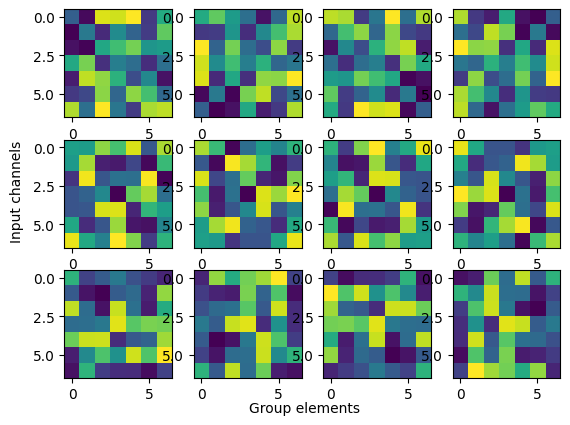

In [12]:
# Pick an output channel to visualize (we only have 1 in this case)
out_channel_idx = 0

# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(ik.in_channels, ik.group.elements().numel())

for in_channel in range(ik.in_channels):
    for group_elem in range(ik.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

We want to take as input a feature map defined over $R^2$ and return a feature map $R^2 \rtimes H$, where features under different transformations $h \epsilon H$ are disentangled along the $H$ axis

In [13]:
class LiftingConvolution(nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.kernel = LiftingKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )
        self.padding = padding

    def forward(self, x):

        conv_kernels = self.kernel.sample()
        # the total number of output channels is # group elements * out channels. we can make use of pytorch to do that 
        # the reshape makes the shape (4, 3, 7, 7), which corresponds to 4 output channels, each obtained by a 3 x 7 x 7 kernel that performs convolution over all 3 input channels
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
            self.kernel.out_channels * self.kernel.group.elements().numel(), 
            self.kernel.in_channels, 
            self.kernel.kernel_size, 
            self.kernel.kernel_size),
            padding=self.padding
        )
        # shape it back after using pytorch to do the heavy lifting 
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )

        return x

In [14]:
lifting_conv = LiftingConvolution(
    group=C4(order=4),
    kernel_size=5,
    in_channels=3,
    out_channels=8,
    padding=False
)

## Group Convolution

In [15]:
def trilinear_interpolation(signal, grid):
    """ 
    
    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [3, D, H, W] or [3, N, D, H, W]
    """
    # If signal or grid is a 4D array, add a dimension to support grid_sample.
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, D, H, W, 3] instead of [3, N, D, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)
    
    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)
    
    return torch.nn.functional.grid_sample(
        signal, 
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear" # actually trilinear in this case...
    )

In [16]:
class GroupKernel(nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__()
        self.group = group
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # the kernel grid also extends over the group H, as our input feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())


        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels, 
            # this is different as our kernel is now a whole 3D block over the group and not just 3D over in_channels. 
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

    def create_transformed_grid_R2xH(self):
        """Transform the created grid over R^2 \rtimes H by the group action of each group element in H"""

        group_elements = self.group.elements()

        # this is the same as before, now we have a stack of grids which we get after applying the group action to the initial kernel
        transformed_grid_R2 = []
        for inv in self.group.inverse(group_elements):
            transformed_grid_R2.append(
                self.group.left_action_on_R2(inv, self.grid_R2)
            )
        transformed_grid_R2 = torch.stack(transformed_grid_R2, dim=1)

        # print(f"R2 shape: {transformed_grid_R2.shape}")

        # permuting every group element with another group element to end up with grid of shape |H| x |H|
        transformed_grid_H = []
        for inv in self.group.inverse(group_elements):
            transformed_grid_H.append(
                self.group.product(inv, self.grid_H)
            )
        
        transformed_grid_H = torch.stack(transformed_grid_H, dim=1)

        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)

        # print(f"H shape: {transformed_grid_H.shape}")

        # create a combined grid as the product of the grids over R2 and H

        # print("After repeating R2 along the group dimension")
        # print(transformed_grid_R2.view(
        #             2,
        #             group_elements.numel(),
        #             1,
        #             self.kernel_size,
        #             self.kernel_size,
        #         ).repeat(1, 1, group_elements.numel(), 1, 1).shape)
        
        # print("After repeating H along the spatial dimension")
        # print(transformed_grid_H.view(
        #             1,
        #             group_elements.numel(),
        #             group_elements.numel(),
        #             1,
        #             1,
        #         ).repeat(1, 1, 1, self.kernel_size, self.kernel_size).shape)
        
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    2,
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                ).repeat(1, 1, group_elements.numel(), 1, 1),
                transformed_grid_H.view(
                    1,
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                ).repeat(1, 1, 1, self.kernel_size, self.kernel_size)
            ),
            dim=0
        )

        # print(f"Final shape: {transformed_grid.shape}")

        return transformed_grid

    def sample(self):
        """Sample convolution kernels. Returns filter bank extending over all input channels containing kernels transformed for all output group elements"""

        # folding input and output channels for interpolation
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        transformed_weight = []
        for id in range(self.group.elements().numel()):
            transformed_weight.append(
                # each one is [3 x 4 x 7 x 7]
                # which are [x, y, theta], [group_size], [kernel_size], [kernel_size]
                trilinear_interpolation(weight, self.transformed_grid_R2xH[:, id, :, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)

        # separate input and output channels again
        transformed_weight = transformed_weight.view(
            # this is because of torch.stack()
            self.group.elements().numel(),
            # and everything below is the original grid sizes
            self.out_channels, 
            self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        # put out channel before group dimension for pytorch
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [17]:
gk = GroupKernel(
    group=C4(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=8
)

In [18]:
weights = gk.sample()
weights.shape
# [out_channels, group_size, in_channels, group_size, kernel_size, kernel_size]

torch.Size([8, 4, 2, 4, 5, 5])

In [19]:
# ok this makes so much sense, we fold stuff so pytorch can use things
class GroupConvolution(nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):

        super().__init__()

        self.kernel = GroupKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )

        self.padding = padding

    def forward(self, x):

        # we want to fold the in_channels dimension with the group_dimension
        x = x.reshape(
            -1, 
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )

        conv_kernels = self.kernel.sample()

        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(), 
                self.kernel.in_channels * self.kernel.group.elements().numel(), 
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
            padding=self.padding
        )

        # now we reshape the feature maps back to the size that we want which keeps the group structure
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )

        return x

## Group Equivariant Convolution Neural Network

In [20]:
class GroupCNN(nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):

        super().__init__()

        self.lifting_conv = LiftingConvolution(
            group=group,
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )

        self.gconvs = torch.nn.ModuleList()

        # we don't increase the number of channels there in the middle, but the size of the feature map will decrease as a result of 0 padding
        for _ in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    group=group,
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )

        self.projection_layer = AdaptiveAvgPool3d(1)
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        
        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)

        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)
        
        # to ensure equivariance, apply max pooling over group and spatial dims.
        x = self.projection_layer(x).squeeze()

        x = self.final_linear(x)

        return x

## Training

In [21]:
# constants
ROOT = ".data"
VALID_RATIO = 0.9
BATCH_SIZE = 64
DROPOUT = 0.05
OUTPUT_CLASSES = 10
LEARNING_RATE = 0.01
EPOCHS = 5

In [22]:
class RotateTransform:
    """Defining a custom transformation that rotates the image with one of the discrete values given"""

    def __init__(self, angles):
        self.angles = angles
    
    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

In [28]:
class Data():

    def __init__(self, valid_ratio, batch_size):
        
        """Downloads, splits and normalizes the data. Provides dataloaders for training"""

        # calculating mean and standard deviation for normalization

        td = datasets.CIFAR10(root=ROOT,
                            train=True,
                            download=True)
        td.data = torch.tensor(td.data)

        channels = td.data.split(1, dim=-1)
        channel_tensors = [channel.squeeze(-1) for channel in channels]

        means = [z.float().mean() / 255 for z in channel_tensors]
        stds = [z.float().std() / 255 for z in channel_tensors]

        print(f'Calculated mean: {means}')
        print(f'Calculated std: {stds}')

        # defining test transforms and train transforms. 
        # test transforms have random rotation, and train_transforms do not

        rt = RotateTransform([0, 90, 180, 270])

        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=means, std=stds)])
        
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            # rt,
            transforms.RandomRotation(
            [0, 360], transforms.InterpolationMode.BILINEAR, fill=0),
            transforms.Normalize(mean=means, std=stds)])
        
        # downloading the data

        self.train_data = datasets.CIFAR10(root=ROOT,
                                    train=True,
                                    download=True,
                                    transform=self.train_transform)

        self.test_data = datasets.CIFAR10(root=ROOT,
                                train=False,
                                download=True,
                                transform=self.test_transform)
        
        # splitting the training_data into validation and training examples
        
        n_train_examples = int(len(self.train_data) * valid_ratio)
        n_valid_examples = len(self.train_data) - n_train_examples

        self.train_data, self.valid_data = data.random_split(self.train_data,
                                                [n_train_examples, n_valid_examples])

        self.valid_data = copy.deepcopy(self.valid_data)
        self.valid_data.dataset.transform = self.test_transform

        self.train_loader = data.DataLoader(self.train_data,
                                        shuffle=True,
                                        batch_size=batch_size,num_workers=5)

        self.valid_loader = data.DataLoader(self.valid_data,
                                        batch_size=batch_size,num_workers=5)
        
        self.test_loader = data.DataLoader(self.test_data, shuffle=False, batch_size=batch_size, num_workers=5)

Files already downloaded and verified
Calculated mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
Calculated std: [tensor(0.2470), tensor(0.2435), tensor(0.2616)]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


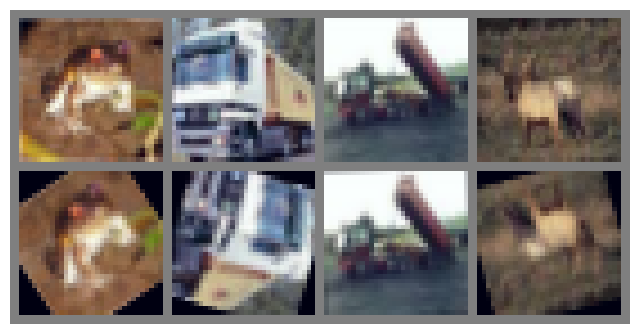

In [29]:
ds = Data(VALID_RATIO, BATCH_SIZE)

train_data = datasets.CIFAR10(root=ROOT,
                                    train=True,
                                    download=True,
                                    transform=ds.train_transform)

NUM_IMAGES = 4
images = [train_data[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_data.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [ds.test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.imshow(img_grid)
plt.axis('off')
plt.show()

In [33]:
class Trainer():

    def __init__(self, model, data, optimizer, criterion, device):
        self.model = model
        self.data = data
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def calculate_accuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc
    
    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    def train(self):

        iterator = self.data.train_loader

        epoch_loss = 0
        epoch_acc = 0

        self.model.train()

        for (x, y) in tqdm(iterator, desc="Training", leave=False):

            x = x.to(self.device)
            y = y.to(self.device)

            self.optimizer.zero_grad()

            y_pred = self.model(x)

            loss = self.criterion(y_pred, y)

            acc = self.calculate_accuracy(y_pred, y)

            loss.backward()

            self.optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self):

        iterator = self.data.valid_loader

        epoch_loss = 0
        epoch_acc = 0

        self.model.eval()

        with torch.no_grad():

            for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(x)

                loss = self.criterion(y_pred, y)

                acc = self.calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

In [35]:
info = Data(VALID_RATIO, BATCH_SIZE);
model = GroupCNN(C4(order=4).to(device), 3, 10, 5, 2, 5);
optimizer = optim.Adam(model.parameters());
criterion = nn.CrossEntropyLoss();
criterion = criterion.to(device);
model(next(iter(info.train_loader))[0].to(device));
trainer = Trainer(model, info, optimizer, criterion, device);

Files already downloaded and verified
Calculated mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
Calculated std: [tensor(0.2470), tensor(0.2435), tensor(0.2616)]
Files already downloaded and verified
Files already downloaded and verified


In [34]:
best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = trainer.train()
    valid_loss, valid_acc = trainer.evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'IMAGENETMODEL.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = trainer.epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]/Users/luisali/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epochs:   0%|          | 0/5 [02:52<?, ?it/s]


TypeError: epoch_time() takes 2 positional arguments but 3 were given